In [24]:
import numpy as np
import pandas as pd
import mne ,os, emd
from scipy import signal
from scipy import stats as st
import neurokit2 as nk
from tqdm import tqdm
from numba import jit
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import mutual_info_classif

In [2]:
db_patients_path  = '/home/tusharsingh/DATAs/Database_patients'
db_subjects_path  = '/home/tusharsingh/DATAs/Database_subjects'

scoring_criteria = 'HypnogramR&K_'
def file_path_aggregator(scoring_criteria, path, count, prefix):
    edf = [os.path.join(path,prefix + str(i) + '.edf') for i in range(1, count + 1)]
    txt = [os.path.join(path,scoring_criteria + prefix + str(i) + '.txt') for i in range(1, count + 1)]
    return list(zip(edf, txt))

def data_aggregator(path_list):
    EDF = []
    label = []
    for edf, txt in path_list:
        name = txt[-13:]
        e = mne.io.read_raw_edf(edf, verbose = False)
        # because channel name is not consistent in differnt files, 
        # hence need to search for EOG1 prefix
        x = sorted([a for a in e.ch_names if 'EOG1' in a])[0]
        # print(x)
        edf = e.pick(x).to_data_frame()[x].values
        sos = signal.butter(8, (0.5,49.5), 'bandpass', fs = 200, output = "sos")
        edf = signal.sosfilt(sos, edf)
        with open(txt,'r') as f:
            lines = f.readlines()[1:]
            lines = [int(x[:-1]) for x in lines]
            txt = np.array(lines)
            # sleep
            txt[txt != 5] = 1
            # wake
            txt[txt == 5] = 0

        txt = txt[:4*(txt.size//4)]
        edf = edf[:txt.size * 1000]
        txt = txt.reshape(-1,4)
        edf = edf.reshape(-1,4000)

        # if not (txt[:,0] == np.mean(txt, axis = 1)).all():
        #     print(name, "     edf_shape", edf.shape, " txt_shape", txt.shape)
        #     print(txt[txt[:,0] != np.mean(txt, axis = 1)])

        index = txt[:,0] == np.mean(txt, axis = 1)
        txt = txt[index]
        edf = edf[index]
        txt = txt[:,0]
        label.append(txt)
        EDF.append(edf)
        
    # return list(zip(EDF, label))
    EDF = np.vstack(EDF)
    label = np.concatenate(label)
    return EDF, label

In [3]:
patient_paths = file_path_aggregator(scoring_criteria, db_patients_path, 27, 'patient')
subject_paths = file_path_aggregator(scoring_criteria, db_subjects_path, 20, 'subject')

patient_data = data_aggregator(patient_paths)
subject_data = data_aggregator(subject_paths)

In [32]:
# sub_eog, sub_label = subject_data
# print(sub_eog.shape, sub_label.shape)
# np.savez('/home/tusharsingh/DATAs/sub_data', a=sub_eog, b=sub_label)

data = np.load('/home/tusharsingh/DATAs/sub_data.npz')
sub_eog, sub_label = data['a'], data['b']

unique, counts = np.unique(sub_label, return_counts=True)
print (np.asarray((unique, counts)).T)

[[    0  5601]
 [    1 24800]]


In [33]:
# pat_eog, pat_label = patient_data
# print(pat_eog.shape, pat_label.shape)
# np.savez('/home/tusharsingh/DATAs/pat_data', a=pat_eog, b=pat_label)

data = np.load('/home/tusharsingh/DATAs/pat_data.npz')
pat_eog, pat_label = data['a'], data['b']

unique, counts = np.unique(pat_label, return_counts=True)
print (np.asarray((unique, counts)).T)

[[    0 11552]
 [    1 30877]]


In [47]:
def feature_maker(X):
    imf = emd.sift.ensemble_sift(X, max_imfs=5,nprocesses=5, noise_mode = 'flip') # no way to set seed in this function
    # emd.plotting.plot_imfs(imf)
    imf = imf.T
    imf = np.vstack((imf, X - np.sum(imf, axis = 0)))
    IP, IF, IA = emd.spectra.frequency_transform(imf, 200, 'hilbert')
    f, hht = emd.spectra.hilberthuang(IF, IA, sample_rate=200)
    approx_entropy = nk.entropy_approximate(X)[0]
    del(IA)
    IMF_mean = np.mean(imf, axis = 1)
    IMF_mode = st.mode(imf, axis = 1)[0].flatten()
    IMF_sdiv = st.tstd(imf, axis = 1)
    IMF_kurt = st.kurtosis(imf, axis = 1)
    IMF_skew = st.skew(imf, axis = 1)
    feature = np.hstack([IMF_mean, IMF_mode, IMF_sdiv, IMF_kurt, IMF_skew])

    IF_mean = np.mean(IF,axis = 1)
    IF_median = np.median(IF, axis = 1)
    IF_variance = np.var(IF, axis = 1)
    IF_counChange = np.sum((np.diff(IF, axis = 1) != 0), axis = 1)
    IE_median = np.median(IP, axis = 1)

    feature = np.hstack([feature,IF_median, IF_mean, IF_variance, IF_counChange, IE_median])

    total_power = np.sum(hht[(0.5 <= f) & (f <= 49.5)])
    # relative power features
    theta = np.sum(hht[(3.5 <= f) & (f <= 7.5)]) / total_power
    alpha = np.sum(hht[(8.5 <= f) & (f <= 11)]) / total_power
    beta = np.sum(hht[(15.5 <= f) & (f <= 30)]) / total_power
    gamma = np.sum(hht[(30 <= f) & (f <= 49.5)]) / total_power
    delta = np.sum(hht[(0.5 <= f) & (f <= 3.5)]) / total_power
    k_complex_spindle = (np.sum(hht[(8.5 <= f) & (f <= 1.5)]) + \
        np.sum(hht[(11 <= f) & (f <= 15)])) / total_power
    alpha2theta = alpha / theta

    Relative = np.array([alpha, beta, gamma, delta, k_complex_spindle, alpha2theta,approx_entropy])
    feature = np.hstack([feature, Relative])
    return feature[:]


In [49]:
feature_maker(pat_eog[0])

array([-3.53740276e+03,  4.07717995e+04,  2.44657570e+05, -5.81691566e+05,
        1.67513413e+05,  1.34633829e+05, -3.17045974e+06, -1.28316533e+07,
       -1.57323870e+07, -1.36181848e+07, -9.81559343e+06, -4.49150698e+06,
        2.54043658e+05,  2.36271162e+06,  3.97457725e+06,  4.77537031e+06,
        3.89161976e+06,  2.11965436e+06,  2.77952122e+01,  5.19260029e+00,
        1.88633871e+00,  5.39511628e-01, -1.88260599e-01, -8.34245272e-01,
       -1.07793034e+00,  5.42151788e-02, -6.62180242e-02,  2.27677860e-01,
       -2.91584934e-02, -1.35512747e-01,  2.06298088e+01,  2.06298088e+01,
        2.75954092e+01,  1.61393653e+01,  4.23788918e-15,  1.38046101e-14,
        2.09931826e+01,  2.09931826e+01,  2.84536990e+01,  1.64343572e+01,
       -8.81958913e-02, -8.81958913e-02,  5.43391767e+02,  5.43391767e+02,
        4.07904768e+02,  1.32824927e+02,  6.09596012e+01,  6.09596012e+01,
        3.99900000e+03,  3.99900000e+03,  3.99900000e+03,  3.99900000e+03,
        3.99900000e+03,  

In [ ]:
def linear_process(X):
    final_feature = np.zeros((X.shape[0],67))
    for i in range(X.shape[0]):
        final_feature[i] = feature_maker(X[i])
    return final_feature

import concurrent.futures
with concurrent.futures.ProcessPoolExecutor() as executor:
    a = executor.submit(linear_process, pat_eog[:10000,:])
    b = executor.submit(linear_process, pat_eog[10000:20000,:])
    c = executor.submit(linear_process, pat_eog[20000:30000,:])
    d = executor.submit(linear_process, pat_eog[30000:,:])

    e = executor.submit(linear_process, sub_eog[:10000,:])
    f = executor.submit(linear_process, sub_eog[10000:20000:,:])
    g = executor.submit(linear_process, sub_eog[20000:,:])

    pat_67 = np.vstack((a.result(), b.result(), c.result(), d.result()))
    sub_67 = np.vstack((e.result(), f.result(), g.result()))


storing_path = '/home/tusharsingh/DATAs/'
np.savez(storing_path + 'pat_data_67', a=pat_67, b=pat_label)
np.savez(storing_path + 'sub_data_67', a=sub_67, b=sub_label)

In [5]:
storing_path = '/home/tusharsingh/DATAs/'

data = np.load(storing_path + 'pat_data_67.npz')
pat_X, pat_y = data['a'], data['b']

data = np.load(storing_path + 'sub_data_67.npz')
sub_X, sub_y = data['a'], data['b']

## Testing on patents

In [26]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(pat_X, pat_y, test_size=0.25, random_state=0, stratify = pat_y)

feature selection

In [ ]:
from imblearn.ensemble import RUSBoostClassifier
def best_group(X, y): #best feature set for one trial
    best = 0
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify = y)
    mi_values = np.argsort(mutual_info_classif(X_train, y_train))

    for i in range(15, 66):
        indices = mi_values[-i:]
        train, test = X_train[ :, indices], X_test[:, indices]
        clf = make_pipeline(StandardScaler(), RUSBoostClassifier())
        clf.fit(train, y_train)
        
        score = clf.score(test, y_test)
        if score > best:
            best_features = indices
            best = score
    return best_features

import concurrent.futures
with concurrent.futures.ProcessPoolExecutor() as executor:
    l = [executor.submit(best_group, X_train, y_train) for i in range(5)]
    l = [each.result().tolist() for each in l]

l = [set(each) for each in l]
best_features = set.intersection(*l) # as best features should be selected in all the trials

from scipy.stats import kruskal
final_best_fearures = []
for each in best_features:
    x = X_train[:,each]
    y = y_train
    pvalue = kruskal(x,y)[1]
    if pvalue <= 0.05:
        final_best_fearures.append(each)

print(sorted(final_best_fearures), len(final_best_fearures))


In [28]:
X_train, X_test = X_train[:, sorted(final_best_fearures)], X_test[:, sorted(final_best_fearures)]

In [29]:
clf = clf = make_pipeline(StandardScaler(), RUSBoostClassifier())
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print(score)

0.5903092006033183


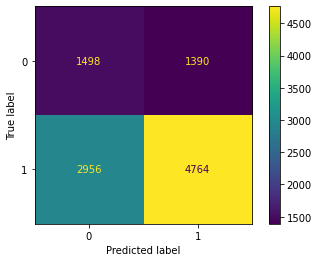

In [30]:
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

testing on subjects

In [21]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(sub_X, sub_y, test_size=0.25, random_state=0, stratify = sub_y)

In [22]:
import concurrent.futures
with concurrent.futures.ProcessPoolExecutor() as executor:
    l = [executor.submit(best_group, X_train, y_train) for i in range(5)]
    l = [each.result().tolist() for each in l]

l = [set(each) for each in l]
best_features = set.intersection(*l)

from scipy.stats import kruskal
final_best_fearures = []
for each in best_features:
    x = X_train[:,each]
    y = y_train
    pvalue = kruskal(x,y)[1]
    if pvalue <= 0.05:
        final_best_fearures.append(each)

print(sorted(final_best_fearures), len(final_best_fearures))


[0, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 17, 18, 21, 22, 24, 29, 35, 36, 37, 39, 40, 41, 44, 45, 48, 50, 52, 53, 59, 61, 62, 63, 65, 66] 36


In [23]:
clf = clf = make_pipeline(StandardScaler(), RUSBoostClassifier())
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print(score)

0.6021576108406789


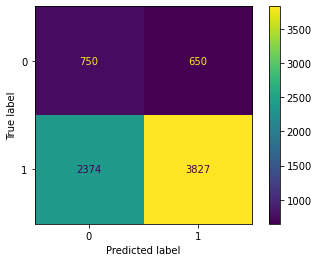

In [25]:
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)